In [2]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import precision_recall_curve,roc_curve


# MNIST

there are 70000 images of size 28*28, each image has 784 features. 
each feature represents one pixel's intensity from 0 to 255 (should be white)

The MNIST dataset is already split to train set (60000) and test set (10000)

shuffle is important since some alg, are sensitive to the order of the train set and they perform poorly if they get many similar instances in a row 

(70000, 784)

(70000,)

(784,)

5.0

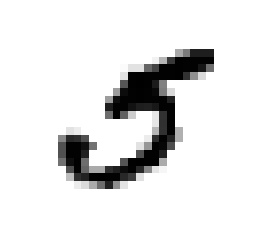

In [3]:
mnist_path = 'mnist-original.mat'

mnist = loadmat(mnist_path)
X = mnist['data'].T
y = mnist['label'][0]
display(X.shape , y.shape)

#peek a digit
some_index = 36000
some_digit = X[some_index]
display(some_digit.shape)
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')

#show y value
display(y[36000])

In [ ]:
# split to train & test 
train_size = 60000
X_train,y_train = X[:train_size],y[:train_size]
X_test,y_test = X[train_size:],y[train_size:]


#shuffle
shuffle_index = np.random.permutation(train_size)
X_train,y_train = X[shuffle_index],y[shuffle_index]


# Train a Binary Classifier - By SGDClassifier
# Stochastic Gradient Descent
The class implements regularized linear classifier (SVM,logistic regression,etc) with SGD training
the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate. 

The model it fits can be controlled with loss parameter
by default, it fits a linear support vector machine (using the 'hinge' loss)
log loss gives logistic regression
perceptron is the linear loss used by the perceptron alg. 

The classifier has the advantage of being capable of handling very large dataset efficiently, and is also wekk suited for online learning

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

display(y_train)
display(y_train_5, y_test_5)

In [ ]:
sgd_clf = SGDClassifier(random_state=0,max_iter=50)
sgd_clf.fit(X_train,y_train_5)

#display(some_digit)
sgd_clf.predict([some_digit])

# Performance Measure - cross_val_score()
evaluating a classifier is often significantly trickier than evaluating a regressor
a good start is to use cross-validation

the **cross_val_score()** return the ratio of correct predictions. 

~95% looks good but if we will write & check the Never5Classifier , we will get also 90% accuracy. 
This is because only about 10% of the images are 5s. so if you always guess than an image is not 5 , you will get right about 90% of the time

This demonstrates why accuracy is generally not the preferred performance measure for classifier, especially when you are dealing with skewed datasets (סט נתונים מוטה)

In [ ]:
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')



In [ ]:
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
        
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

# Performance Measure - Confusion Matrix - cross_val_predict()

a much better way to evaluate the performance of a classifier is to look at the confusion matrix
The idea is to count the number of times instances of class A are classified as class B

for example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and the 3rd column of the confusion matrix
To compute the confusion matrix, you first need to have a set of predictions

You could make predictions on the test set, but let's keep it untouched for now
you want to use yout test set only at the very end of your project, once you have a classifier you are ready to launch

Instead of, you can use the **cross_val_predict() **

Like the cross_val_score() the cross_val_predict() also performs K-cross validation, but instead of returning the evaluations scores, it returns for each element the prediction that was obtained for that element when it was in the test set
only cross validation strategies that assign all elements to a test set exactly once can be used (otherise  an exception is raised)


In [ ]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

conf_mat = confusion_matrix(y_train_5,y_train_pred)
conf_mat

In [ ]:
#visualize confusion matrix
sns.heatmap(conf_mat,square=True,annot=True,cmap='Blues',fmt='d',cbar=False)
plt.xlabel('Predicted Value',fontsize=12)
plt.ylabel('True Value',fontsize=12)

### accuracy / precision / recall (sensitivity or true positive rate TPR) / F1 score

In [ ]:
# TN FP
# FN TP

# accuracy = (TN + TP) / (TN + TP + FN + FP)
accuracy = (53177 + 4479) / (53177 + 1402 + 942 + 4479)
display('accuracy',accuracy)

# precision = (TP) / (TP + FP)
# accuracy of the positive prediction
precision = 4479 / (4479 + 1402)
display('precision',precision)

# recall = (TP) / (TP + FN)
# ratio of positive instances that are correctly detected 
recall = 4479 / (4479 + 942)
display('recall',recall)

In [ ]:
precision_score(y_train_5,y_train_pred) , recall_score(y_train_5,y_train_pred)
#0.76 - when it claims an image represent 5, it is correct only 76% (precision_score)
#0.82 - only detect 82% of the 5s (recall_score)

In [ ]:
# F1 = 2 / ( (1/precision) + (1/recall)) = 2 * ( (precision * recall) / (precision + recall) ) =  2TP / ( 2TP + FN + FP)
# מאחר שממוצע הרמוני של קבוצת מספרים נוטה לעבר המספר הקטן ביותר שבה, הוא נוטה למזער את ההשפעה של מספרים גדולים ולהגדיל את ההשפעה של מספרים קטנים.

# The harmonic mean give much more weight to low values
# Thus, a classifier will only get a high F1 score if both recall and precision are high

f1_score(y_train_5,y_train_pred)


In [4]:
#Ex F1
d = {'expected':[1,1,0,1,0,0,1,0,0,0],
    'predicted':[1,0,0,1,0,0,1,1,1,0]}

df = pd.DataFrame(d)

array([[4, 2],
       [1, 3]], dtype=int64)

0.6

0.75

0.6666666666666665

Text(33.0, 0.5, 'True Value')

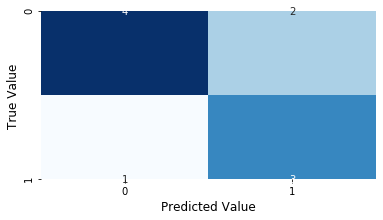

In [6]:
#confusion matrix by hand
# TN - 4 ex 0 pre 0 (4) FP ex 0 pre 1 (2)  
# FN - 2 ex 1 pre 0 (1) TP ex 1 pre 1 (3) 
y_expected =  df['expected']
y_predicted = df['predicted']

conf_mat_ex = confusion_matrix(y_expected,y_predicted)
display(conf_mat_ex)

display(precision_score(y_expected,y_predicted) , recall_score(y_expected,y_predicted))
display(f1_score(y_expected,y_predicted))

#visualize confusion matrix
sns.heatmap(conf_mat_ex,square=True,annot=True,cmap='Blues',fmt='d',cbar=False)
plt.xlabel('Predicted Value',fontsize=12)
plt.ylabel('True Value',fontsize=12)

### precision / recall TradeOff - decision_function()

In [99]:
mnist_path = 'mnist-original.mat'

mnist = loadmat(mnist_path)
X = mnist['data'].T
y = mnist['label'][0]

#peek a digit
some_index = 36000
some_digit = X[some_index]
some_digit_image = some_digit.reshape(28,28)

# split to train & test & #shuffle
train_size = 60000
shuffle_index = np.random.permutation(train_size)
X_train,y_train = X[shuffle_index],y[shuffle_index]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=0,max_iter=50)
sgd_clf.fit(X_train,y_train_5)

display(y_train_5.shape)

y_scores = sgd_clf.decision_function([some_digit])
display("y_scores",y_scores)


threshold = 0
y_digit_pred = (y_scores > threshold)
#display(y_digit_pred)

threshold = 10000
y_digit_pred = (y_scores > threshold)
#display(y_digit_pred)

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')
#display(y_scores)

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

display(precisions, recalls, thresholds)
display(precisions.shape, recalls.shape, thresholds.shape)
display(y_train_5.shape,y_scores.shape)



C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


(60000,)

'y_scores'

array([26019.14257849])

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.09041329, 0.09039812, 0.09039963, ..., 1.        , 1.        ,
       1.        ])

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

array([-286065.94203309, -285192.78817344, -282469.37006111, ...,
        104392.71886582,  107786.82435801,  110412.90263191])

(59959,)

(59959,)

(59958,)

(60000,)

(60000,)

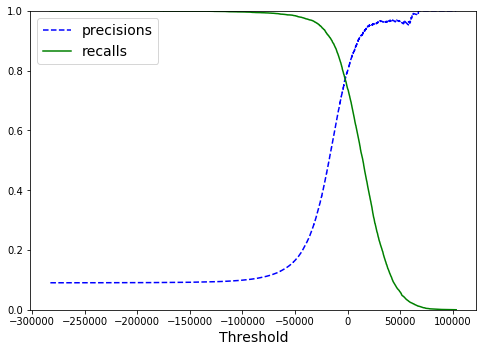

In [37]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.figure(figsize=(8,5.5))
    plt.plot(thresholds,precisions[:-1],'b--',label='precisions')
    plt.plot(thresholds,recalls[:-1],'g-',label='recalls')
    plt.xlabel('Threshold',fontsize=14)
    plt.legend(loc='upper left',fontsize=14)
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

### ROC Curve

[[1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.8333333333333334],
 [0.8333333333333334],
 [0.6666666666666666],
 [0.5],
 [0.5],
 [0.3333333333333333],
 [0.16666666666666666],
 [0.0]]

[[1.0],
 [0.8333333333333334],
 [0.6666666666666666],
 [0.5],
 [0.3333333333333333],
 [0.3333333333333333],
 [0.16666666666666666],
 [0.16666666666666666],
 [0.16666666666666666],
 [0.0],
 [0.0],
 [0.0],
 [0.0]]

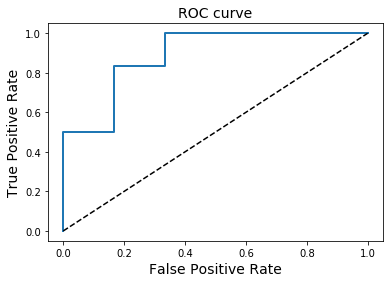

In [93]:
#ex print ROC curve for data in oage 240
d = {'x_train':[8,7,3,9,5,2,5,5,6,5,5,5],
    'y_5':[0,0,0,0,1,0,1,1,0,1,1,1],
    'y_not_5':[1,1,1,1,0,1,0,0,1,0,0,0]}

df = pd.DataFrame(d)

y_5 = df['y_5']
y_not_5 = df['y_not_5']
#display(y)



#fpr = fp / fp + tn
#tpr = tp / tp + fn



#       TPR   FPR  TP  FP   
#        6/6   6/6  6  6 
# 8       6/6   5/6  6  5
# 7       6/6   4/6  6  4      
# 3       6/6   3/6  6  3
# 9       6/6   2/6  6  2
# 5       5/6   2/6  5  2
# 2       5/6   1/6  5  1
# 5       4/6   1/6  4  1
# 5       3/6   1/6  3  1
# 6       3/6   0/6  3  0
# 5       2/6   0/6  2  0
# 5       1/6   0/6  1  0
# 5       0/6   0/6  0  0




P = 6
N = 6
fpr = []
tpr = []

for i in range(len(y_5) + 1):
    FP = y_5[i:].sum()
    TP = y_not_5[i:].sum()
    #display((FP,TP))
    fpr.append([FP / N])
    tpr.append([TP / P])


display(fpr)
display(tpr)

def plot_roc_curve(tpr,fpr,label=None):
    plt.plot(tpr,fpr,lw=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.title('ROC curve',fontsize=14)

plot_roc_curve(tpr,fpr)
    


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


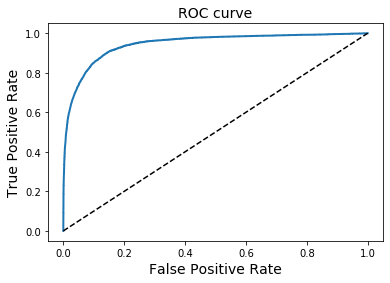

In [96]:
mnist_path = 'mnist-original.mat'

mnist = loadmat(mnist_path)
X = mnist['data'].T
y = mnist['label'][0]

#peek a digit
some_index = 36000
some_digit = X[some_index]
some_digit_image = some_digit.reshape(28,28)

# split to train & test & #shuffle
train_size = 60000
shuffle_index = np.random.permutation(train_size)
X_train,y_train = X[shuffle_index],y[shuffle_index]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=0,max_iter=50)
sgd_clf.fit(X_train,y_train_5)

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(tpr,fpr,label=None):
    plt.plot(fpr,tpr,lw=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.title('ROC curve',fontsize=14)

plot_roc_curve(tpr,fpr)